## HW 3
### Due Apr. 15th by end of day.
### Name your notebook by firstname.lastname.hw3.ipynb and email it to zhang@csc.lsu.edu

In this HW, we take a look at text processing using RNN based on LSTM. Given a review (hundred to thousand words long) about a movie, we want to classify the review as positive or negative (sentiment analysis). A model is given in this notebook that runs RNN, consisting of a single layer of LSTM cells, on the word sequence of the rewiews. Each review is transformed into a vector, which is the average of the LSTM vectors over the sequence. A softmax layer is then used to classify the reviews based on the LSTM vector representation. 

Your goal is to train the model and gain some idea on the computation challenge when training "deep" model for a large number of iterations.  

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import time

import numpy
import theano
import theano.tensor as T

from lstm import load_data, prepare_data, batches_idx, lstm_layer, rmsprop

### Model meta parameters

 - n_hidden: # of neurons in the LSTM layer
 - n_words: # of words in the dictionary. We use most frequent words. All other words are treated as unknown.
 - n_sample: max size (# of reviews) of the train dataset and the test dataset. (We may not be able to reach the max because if we want only reviews up to 50 words, there may be less than max such reviews in the whole data collection.)  
 - maxlen: max length in number of words for a review to be considered. Review longer than this will be ignored. This is also the # of recurrent steps.


In [5]:
n_hidden = 10
n_words = 500
n_sample = 1000
maxlen = 50

### Load data. 
First parameter to load_data function should be the path to the data files (*.pkl.gz) on your computer.

In [6]:
train, test, translate = load_data('./', n_words, n_sample, maxlen)

In [7]:
print 'num of pos in train:', numpy.sum(train[1]), 'out of', len(train[1])
print 'num of pos in test:', numpy.sum(test[1]), 'out of', len(test[1])

num of pos in train: 169 out of 269
num of pos in test: 163 out of 293


In [8]:
def build_model(n_hidden, n_words):

    x = T.matrix('x', dtype='int64')
    mask = T.matrix('mask', dtype='float64')
    y = T.vector('y', dtype='int64')

    # embedding params
    randn = numpy.random.rand(n_words, n_hidden)
    Wemb = theano.shared(0.01 * randn)
    
    #lstm layer
    lstm = lstm_layer(n_hidden)
    
    # classifier params
    CU = theano.shared(0.01 * numpy.random.randn(n_hidden, 2))
    Cb = theano.shared(numpy.zeros((2,)))
    params = lstm.params + [Wemb, CU, Cb]
    
    
    n_timesteps = x.shape[0]
    n_samples = x.shape[1]

    emb = Wemb[x.flatten()].reshape([n_timesteps, n_samples, n_hidden])
    proj = lstm.calc_lstm(emb, mask)
    proj = (proj * mask[:, :, None]).sum(axis=0)
    proj = proj / mask.sum(axis=0)[:, None]

    pred = T.nnet.softmax(T.dot(proj, CU) + Cb)

    f_pred = theano.function([x, mask], pred.argmax(axis=1), name='f_pred')

    off = 1e-8
    cost = -T.log(pred[T.arange(n_samples), y] + off).mean()

    return x, mask, y, params, cost, f_pred

In [9]:
(x, mask, y, params, cost, f_pred) = build_model(n_hidden, n_words)
grads = T.grad(cost, params)    

lr = T.scalar(name='lr')
f_grad_shared, f_update = rmsprop(lr, params, grads, x, mask, y, cost)

lrate=0.1
updates = [(p, p - lrate * g) for p, g in zip(params, grads)]
f_sgd = theano.function([x, mask, y], cost, updates=updates)

/usr/local/lib/python2.7/dist-packages/theano/gof/cmodule.py:293: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  rval = __import__(module_name, {}, {}, [module_name])


In [10]:
nepoch = 5000
cc = numpy.zeros((nepoch,))
t0 = time.time()
for i in range(nepoch):
    cost = 0
    for train_index in batches_idx(len(train[0]), 100):
        y = [train[1][t] for t in train_index]
        x = [train[0][t]for t in train_index]
        x, mask, y = prepare_data(x, y)
        
        cost += f_grad_shared(x, mask, y)
        f_update(lrate)
        #cost += f_sgd(x, mask, y)
        
    print 'iteration:', i, 'cost=', cost
    #print i,
    cc[i] = cost
print 'run time:', (time.time()-t0)/60.0  #training time in min.

iteration: 0 cost= 2.07911679112
iteration: 1 cost= 2.07732215908
iteration: 2 cost= 2.07478270257
iteration: 3 cost= 2.07190186525
iteration: 4 cost= 2.06887162924
iteration: 5 cost= 2.06579084875
iteration: 6 cost= 2.06271086105
iteration: 7 cost= 2.05965779173
iteration: 8 cost= 2.05664454887
iteration: 9 cost= 2.05367753134
iteration: 10 cost= 2.05076039977
iteration: 11 cost= 2.04789613201
iteration: 12 cost= 2.0450880449
iteration: 13 cost= 2.04234018395
iteration: 14 cost= 2.03965733098
iteration: 15 cost= 2.03704479354
iteration: 16 cost= 2.03450808818
iteration: 17 cost= 2.032052596
iteration: 18 cost= 2.02968324368
iteration: 19 cost= 2.02740424339
iteration: 20 cost= 2.02521890835
iteration: 21 cost= 2.02312954788
iteration: 22 cost= 2.0211374359
iteration: 23 cost= 2.01924284108
iteration: 24 cost= 2.01744510368
iteration: 25 cost= 2.01574274368
iteration: 26 cost= 2.01413358631
iteration: 27 cost= 2.01261489325
iteration: 28 cost= 2.01118349081
iteration: 29 cost= 2.009835

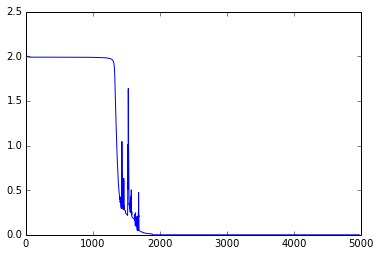

In [55]:
plot(cc[20:])

In [56]:
np.min(cc)

0.0

In [53]:
tx, tmask, ty = prepare_data(test[0], test[1])
py = f_pred(tx, tmask)
print 'error rate =', 1.0*numpy.sum(numpy.abs(ty - py))/len(test[0])


error rate = 0.378839590444


## Task 1
Investigate test error rate with respect to training iterations. 

  - Plot error rate for test data v.s. number of iterations.  
  
Train the model until "cost" gets close to 0 (smaller than 0.01). You don't need to get error rate every iteration. Rather, every 250 or 500 iterations, call f_pred to make prediction on the test data and calculated error rate (an example is given above for prediction and error rate calculation).

### Make plot on this notebook and submit the notebook with the plot. I'd like to see the plot besides your code.

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 error rate = 0.443686006826
250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 27

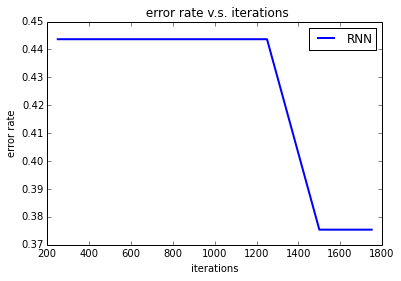

In [52]:

n_hidden = 10
n_words = 500
n_sample = 1000
maxlen = 50

error_rate_data = []
error_rate_data_x_iters = []

(x, mask, y, params, cost, f_pred) = build_model(n_hidden, n_words)
grads = T.grad(cost, params)    

lr = T.scalar(name='lr')
f_grad_shared, f_update = rmsprop(lr, params, grads, x, mask, y, cost)

lrate=0.1
updates = [(p, p - lrate * g) for p, g in zip(params, grads)]
f_sgd = theano.function([x, mask, y], cost, updates=updates)

nepoch = 5000
cc = numpy.zeros((nepoch,))
t0 = time.time()
for i in range(nepoch):
        cost = 0
        for train_index in batches_idx(len(train[0]), 100):
            y = [train[1][t] for t in train_index]
            x = [train[0][t]for t in train_index]
            x, mask, y = prepare_data(x, y)
        
            cost += f_grad_shared(x, mask, y)
            f_update(lrate)
            #cost += f_sgd(x, mask, y)
        
        #print 'iteration:', i, 'cost=', cost
        print i,
        cc[i] = cost
        if cost < 0.01:
            break
            
        if not (i+1) % 250:
            tx, tmask, ty = prepare_data(test[0], test[1])
            py = f_pred(tx, tmask)
            print 'error rate =', 1.0*numpy.sum(numpy.abs(ty - py))/len(test[0])
            error_rate_data.append(1.0*numpy.sum(numpy.abs(ty - py))/len(test[0]))
            error_rate_data_x_iters.append(i + 1)
            
print 'run time:', (time.time()-t0)/60.0  #training time in min.

print error_rate_data

import matplotlib.pyplot as pl
pl.title(' error rate v.s. iterations')
pl.plot(error_rate_data_x_iters, error_rate_data, lw=2, label = 'RNN')
pl.legend()
pl.xlabel('iterations')
pl.ylabel('error rate')

pl.show()


## Task 2
Investigate training time with respect to the following parameters:
  - n_hidden (# of neurons in the LSTM layer)
  - maxlen (max length in number of words for a review), i.e., # of recurrent steps

Fix the number of training iterations (i.e., 200), vary (increase the values of) the parameters and measure the training time. (Don't make small changes of values, e.g., from 10 to 11. You should make significant change of the values, e.g., from 10 to 20 to 50 to 100 etc.) Try several values and make the following plots: 
  - training time v.s. n_hidden
  - training time v.s. maxlen
  
### Make plot on this notebook and submit the notebook with the plot. I'd like to see the plot besides your code.

In [30]:
batch_n_hidden = [10,20,30,40,50]
batch_maxlen = [50,100,150,200,250]

n_hidden = 10
n_words = 500
n_sample = 1000
maxlen = 50

time_data_batch_n_hidden = []
for n_hidden in batch_n_hidden:
    (x, mask, y, params, cost, f_pred) = build_model(n_hidden, n_words)
    grads = T.grad(cost, params)    

    lr = T.scalar(name='lr')
    f_grad_shared, f_update = rmsprop(lr, params, grads, x, mask, y, cost)

    lrate=0.1
    updates = [(p, p - lrate * g) for p, g in zip(params, grads)]
    f_sgd = theano.function([x, mask, y], cost, updates=updates)

    nepoch = 200
    cc = numpy.zeros((nepoch,))
    t0 = time.time()
    for i in range(nepoch):
        cost = 0
        for train_index in batches_idx(len(train[0]), 100):
            y = [train[1][t] for t in train_index]
            x = [train[0][t]for t in train_index]
            x, mask, y = prepare_data(x, y)
        
            cost += f_grad_shared(x, mask, y)
            f_update(lrate)
            #cost += f_sgd(x, mask, y)
        
        #print 'iteration:', i, 'cost=', cost
        print i,
        cc[i] = cost
    print 'run time:', (time.time()-t0)/60.0  #training time in min.
    time_data_batch_n_hidden.append((time.time()-t0)/60.0)
print time_data_batch_n_hidden

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 run time: 0.93374830087
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98

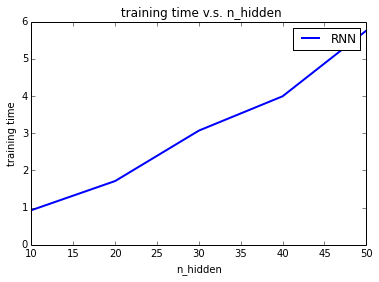

In [32]:
import matplotlib.pyplot as pl
pl.title(' training time v.s. n_hidden')
pl.plot(batch_n_hidden, time_data_batch_n_hidden, lw=2, label = 'RNN')
pl.legend()
pl.xlabel('n_hidden')
pl.ylabel('training time')

pl.show()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 run time: 0.988088667393
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 9

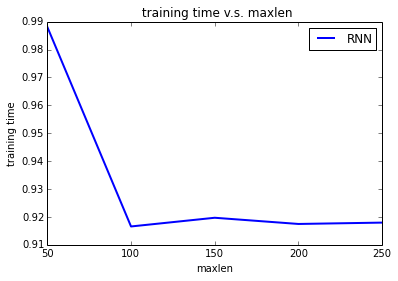

In [33]:
batch_n_hidden = [10,20,30,40,50]
batch_maxlen = [50,100,150,200,250]

n_hidden = 10
n_words = 500
n_sample = 1000
maxlen = 50

time_data_batch_maxlen = []
for maxlen in batch_maxlen:
    (x, mask, y, params, cost, f_pred) = build_model(n_hidden, n_words)
    grads = T.grad(cost, params)    

    lr = T.scalar(name='lr')
    f_grad_shared, f_update = rmsprop(lr, params, grads, x, mask, y, cost)

    lrate=0.1
    updates = [(p, p - lrate * g) for p, g in zip(params, grads)]
    f_sgd = theano.function([x, mask, y], cost, updates=updates)

    nepoch = 200
    cc = numpy.zeros((nepoch,))
    t0 = time.time()
    for i in range(nepoch):
        cost = 0
        for train_index in batches_idx(len(train[0]), 100):
            y = [train[1][t] for t in train_index]
            x = [train[0][t]for t in train_index]
            x, mask, y = prepare_data(x, y)
        
            cost += f_grad_shared(x, mask, y)
            f_update(lrate)
            #cost += f_sgd(x, mask, y)
        
        #print 'iteration:', i, 'cost=', cost
        print i,
        cc[i] = cost
    print 'run time:', (time.time()-t0)/60.0  #training time in min.
    time_data_batch_maxlen.append((time.time()-t0)/60.0)
print time_data_batch_maxlen

import matplotlib.pyplot as pl
pl.title(' training time v.s. maxlen')
pl.plot(batch_maxlen, time_data_batch_maxlen, lw=2, label = 'RNN')
pl.legend()
pl.xlabel('maxlen')
pl.ylabel('training time')

pl.show()